In [19]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
from PIL import Image
import os
import pandas as pd
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
from tqdm import tqdm
from torchinfo import summary as tsummary
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

Using device: cpu


# Prep DATASET

In [20]:
class SeqDataset(Dataset):
    def __init__(self, csv_path, seq_root, seq_len=30, transform=None, augment=False):
        self.df = pd.read_csv(csv_path)
        self.seq_root = seq_root
        self.seq_len = seq_len
        self.transform = transform
        self.augment = augment

        self.color_aug = transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02
        )

    def __len__(self):
        return len(self.df)

    def augment_sequence(self, frames):
        if random.random() < 0.5:
            frames = [cv2.flip(f, 1) for f in frames]
        # rotation
        if random.random() < 0.3:
            angle = random.uniform(-5, 5)
            h, w = frames[0].shape[:2]
            M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
            frames = [cv2.warpAffine(f, M, (w, h)) for f in frames]

        # noise
        if random.random() < 0.3:
            noise = np.random.normal(0, 4, frames[0].shape).astype(np.uint8)
            frames = [cv2.add(f, noise) for f in frames]

        # color jitter
        if random.random() < 0.3:
            frames_pil = [transforms.ToPILImage()(f) for f in frames]
            frames_pil = [self.color_aug(im) for im in frames_pil]
            frames = [np.array(im) for im in frames_pil]

        return frames

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        seq_name = row["sequence"]
        label = row["label"]

        seq_dir = os.path.join(self.seq_root, seq_name)

        frames = []
        for i in range(1, self.seq_len + 1):
            img_path = os.path.join(seq_dir, f"{i:05d}.jpg")
            img = cv2.imread(img_path)

            if img is None:
                raise FileNotFoundError(f"Missing frame: {img_path}")

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            frames.append(img)

        # apply augmentation
        if self.augment:
            frames = self.augment_sequence(frames)

        # apply transform to each frame
        if self.transform:
            frames = [self.transform(f) for f in frames]
        else:
            frames = [transforms.ToTensor()(f) for f in frames]

        frames = torch.stack(frames, dim=0)  # (T, C, H, W)

        return frames, torch.tensor(label, dtype=torch.float32)

In [21]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ## imgnet stats
])


train_dataset = SeqDataset(
    csv_path = "Data/train/train.csv",
    seq_root = "Data/train/sequences",
    seq_len=30,
    transform=transform,
    augment=False
)
val_dataset = SeqDataset(
    csv_path = "Data/validation/validation.csv",
    seq_root = "Data/validation/sequences",
    seq_len=30,
    transform=transform,
    augment=False
)

test_dataset = SeqDataset(
    csv_path = "Data/test/test.csv",
    seq_root = "Data/test/sequences",
    seq_len=30,
    transform=transform,
    augment=False
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 618
Number of validation samples: 256
Number of test samples: 116


In [22]:
def print_label_stats(csv_path, name="DATASET"):
    df = pd.read_csv(csv_path)

    print(f"\n===== {name} label distribution =====")
    print(df["label"].value_counts())

    print("\n===== Percentage (%) =====")
    print((df["label"].value_counts(normalize=True) * 100).round(2))

    print("\nTotal samples:", len(df))

train_csv = "Data/train/train.csv"
val_csv   = "Data/validation/validation.csv"
test_csv  = "Data/test/test.csv"

print_label_stats(train_csv, "TRAIN")
print_label_stats(val_csv, "VALIDATION")
print_label_stats(test_csv, "TEST")


===== TRAIN label distribution =====
label
0    425
1    193
Name: count, dtype: int64

===== Percentage (%) =====
label
0    68.77
1    31.23
Name: proportion, dtype: float64

Total samples: 618

===== VALIDATION label distribution =====
label
0    151
1    105
Name: count, dtype: int64

===== Percentage (%) =====
label
0    58.98
1    41.02
Name: proportion, dtype: float64

Total samples: 256

===== TEST label distribution =====
label
0    73
1    43
Name: count, dtype: int64

===== Percentage (%) =====
label
0    62.93
1    37.07
Name: proportion, dtype: float64

Total samples: 116


# DEFINE MODEL

### ResNet + LSTM + FC

In [23]:
class RES_LSTM(nn.Module):
    def __init__(self, hidden_size=128, num_layers=2, dropout= 0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        RES = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for p in RES.parameters():
            p.requires_grad = False

        modules = list(RES.children())[:-1]
        self.cnn = nn.Sequential(*modules)
        
        self.lstm = nn.LSTM(
            input_size=512,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)

        feat = self.cnn(x)
        feat = feat.view(B, T, 512)

        out, _ = self.lstm(feat)
        last = out[:, -1, :]

        logit = self.fc(last)
        return logit

    

# Define func Train / Evaludate

In [24]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for (x, y) in tqdm(loader, desc="Training", leave=True):
        x = x.to(device)
        y = y.to(device).float() # label is int so convert to float

        optimizer.zero_grad()
        logits = model(x).squeeze(1)

        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        batch_size = y.size(0)
        total_loss += loss.item() * batch_size

        preds = (torch.sigmoid(logits) >= 0.5).long()
        correct += (preds == y.long()).sum().item()
        total += batch_size

    return total_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    for (x, y) in tqdm(loader, desc="Evaluating", leave=True):
        x = x.to(device)
        y = y.to(device).float()

        logits = model(x).squeeze(1)

        loss = criterion(logits, y)

        batch_size = y.size(0)
        total_loss += loss.item() * batch_size

        preds = (torch.sigmoid(logits) >= 0.5).long()
        correct += (preds == y.long()).sum().item()
        total += batch_size

    return total_loss / total, correct / total

In [ ]:
model = RES_LSTM(hidden_size=128, num_layers=2, dropout=0.0) # (256, 2) - (64, 1)
model = model.to(device)

tsummary(model, input_size=(1, 30, 3, 224, 224))

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Layer (type:depth-idx)                        Output Shape              Param #
RES_LSTM                                      [1, 1]                    --
├─Sequential: 1-1                             [30, 512, 1, 1]           --
│    └─Conv2d: 2-1                            [30, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [30, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [30, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [30, 64, 56, 56]          --
│    └─Sequential: 2-5                        [30, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [30, 64, 56, 56]          (73,984)
│    │    └─BasicBlock: 3-2                   [30, 64, 56, 56]          (73,984)
│    └─Sequential: 2-6                        [30, 128, 28, 28]         --
│    │    └─BasicBlock: 3-3                   [30, 128, 28, 28]         (230,144)
│    │    └─BasicBlock: 3-4                   [30, 128, 28, 28]     

In [26]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 20

best_val_loss = float('inf')
patience = 5
patience_counter = 0

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []
counter = 0
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    counter += 1
    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.3f}, Acc: {train_acc*100:.2f}% | "
        f"Val Loss: {val_loss:.3f}, Acc: {val_acc*100:.2f}%" )
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    if val_loss < best_val_loss: # Early Stopping
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("improved")
    else:
        patience_counter += 1
        print("not improved")
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break


Evaluating: 100%|██████████| 64/64 [02:31<00:00,  2.36s/it]


Epoch 01 | Train Loss: 0.622, Acc: 67.15% | Val Loss: 0.641, Acc: 58.98%
improved


Evaluating: 100%|██████████| 64/64 [02:37<00:00,  2.46s/it]


Epoch 02 | Train Loss: 0.538, Acc: 73.14% | Val Loss: 0.570, Acc: 71.48%
improved


Evaluating: 100%|██████████| 64/64 [02:33<00:00,  2.40s/it]


Epoch 03 | Train Loss: 0.506, Acc: 77.02% | Val Loss: 0.535, Acc: 73.44%
improved


Evaluating: 100%|██████████| 64/64 [02:35<00:00,  2.42s/it]


Epoch 04 | Train Loss: 0.497, Acc: 75.73% | Val Loss: 0.518, Acc: 72.66%
improved


Evaluating: 100%|██████████| 64/64 [02:37<00:00,  2.46s/it]


Epoch 05 | Train Loss: 0.473, Acc: 77.18% | Val Loss: 0.511, Acc: 72.27%
improved


Evaluating: 100%|██████████| 64/64 [02:40<00:00,  2.50s/it]


Epoch 06 | Train Loss: 0.456, Acc: 77.35% | Val Loss: 0.557, Acc: 60.16%
not improved


Evaluating: 100%|██████████| 64/64 [02:38<00:00,  2.48s/it]


Epoch 07 | Train Loss: 0.468, Acc: 77.35% | Val Loss: 0.537, Acc: 66.80%
not improved


Evaluating: 100%|██████████| 64/64 [02:32<00:00,  2.38s/it]


Epoch 08 | Train Loss: 0.459, Acc: 78.32% | Val Loss: 0.502, Acc: 74.22%
improved


Evaluating: 100%|██████████| 64/64 [02:35<00:00,  2.43s/it]


Epoch 09 | Train Loss: 0.459, Acc: 76.70% | Val Loss: 0.477, Acc: 74.61%
improved


Evaluating: 100%|██████████| 64/64 [02:32<00:00,  2.38s/it]


Epoch 10 | Train Loss: 0.447, Acc: 78.32% | Val Loss: 0.493, Acc: 72.66%
not improved


Evaluating: 100%|██████████| 64/64 [02:29<00:00,  2.34s/it]


Epoch 11 | Train Loss: 0.434, Acc: 80.10% | Val Loss: 0.478, Acc: 77.73%
not improved


Evaluating: 100%|██████████| 64/64 [02:30<00:00,  2.35s/it]


Epoch 12 | Train Loss: 0.425, Acc: 78.96% | Val Loss: 0.478, Acc: 76.17%
not improved


Evaluating: 100%|██████████| 64/64 [02:32<00:00,  2.39s/it]


Epoch 13 | Train Loss: 0.417, Acc: 80.58% | Val Loss: 0.465, Acc: 77.34%
improved


Evaluating: 100%|██████████| 64/64 [02:26<00:00,  2.30s/it]


Epoch 14 | Train Loss: 0.419, Acc: 81.07% | Val Loss: 0.451, Acc: 79.30%
improved


Evaluating: 100%|██████████| 64/64 [02:28<00:00,  2.32s/it]


Epoch 15 | Train Loss: 0.391, Acc: 83.82% | Val Loss: 0.483, Acc: 76.17%
not improved


Evaluating: 100%|██████████| 64/64 [02:31<00:00,  2.36s/it]


Epoch 16 | Train Loss: 0.415, Acc: 80.10% | Val Loss: 0.466, Acc: 77.73%
not improved


Evaluating: 100%|██████████| 64/64 [02:28<00:00,  2.31s/it]


Epoch 17 | Train Loss: 0.393, Acc: 80.10% | Val Loss: 0.502, Acc: 74.61%
not improved


Evaluating: 100%|██████████| 64/64 [02:30<00:00,  2.36s/it]


Epoch 18 | Train Loss: 0.418, Acc: 81.39% | Val Loss: 0.481, Acc: 73.83%
not improved


Evaluating: 100%|██████████| 64/64 [02:31<00:00,  2.37s/it]

Epoch 19 | Train Loss: 0.401, Acc: 82.20% | Val Loss: 0.472, Acc: 76.95%
not improved
Early stopping triggered!


In [27]:
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Evaluating: 100%|██████████| 29/29 [01:05<00:00,  2.26s/it]


Test Loss: 0.3682, Test Acc: 0.8448


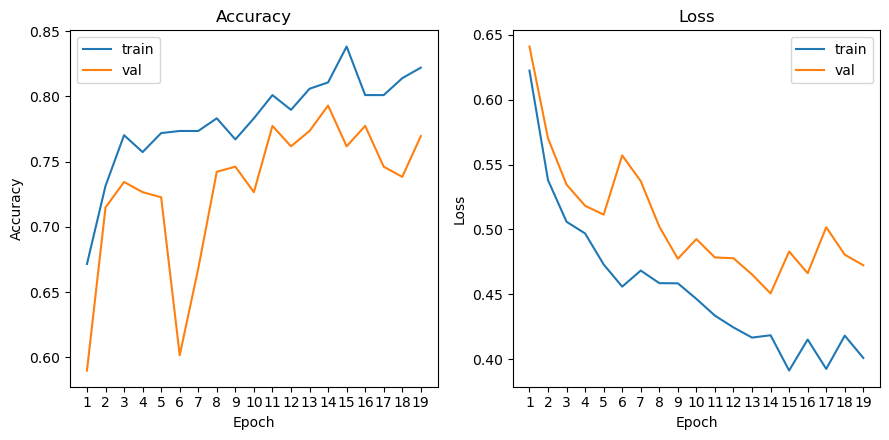

In [28]:

epochs_ax = range(1, counter + 1)

plt.figure(figsize=(9, 4.5))
plt.subplot(1, 2, 1)
plt.plot(epochs_ax, train_accuracies, label='train')
plt.plot(epochs_ax, val_accuracies, label='val')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy")
plt.xticks(list(epochs_ax))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_ax, train_losses, label='train')
plt.plot(epochs_ax, val_losses, label='val')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
plt.xticks(list(epochs_ax))
plt.legend()
plt.tight_layout()
plt.show()
